In [2]:
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import os

# dir = '../test_batch_output'
# dir ='../../NeuronSet2/Random_Cells/surface_meshes2'
# dir ='../../NeuronSet2/Selected_Cells/surface_meshes'
dir ='../../NeuronSet2/jacobs/surface_meshes_new'

fig_dir = 'C:\\Users\\amcsween\\Pictures\\meshing_paper'

In [3]:
log_file = f'{dir}/mesh_stats.db'

conn = sqlite3.connect(log_file)
data = pd.read_sql_query('SELECT * FROM meshing_stats',conn)

In [4]:
swc_timings = np.sum(np.array([data[key] for key in ['extract_swc','reorder_swc','process_swc','initialise_branches']]),axis=0)
individual_mesh_timings =  np.sum(np.array([data[key] for key in ['initialising_individual_meshes','merging_individual_meshes']]),axis=0)
alpha_wrap_timings = np.array( data['alpha_wrap'])
simplify_timings = np.array( data['simplify_mesh'])
tetgen_timings = np.array( data['tetgen'])
cells = list(data['morphology'])

In [5]:
df = pd.DataFrame({'swc':swc_timings,'individual meshes':individual_mesh_timings,'alpha wrapping':alpha_wrap_timings,'mesh simplification':simplify_timings,'tetgen':tetgen_timings})

In [13]:
np.std(df['tetgen'])

10.762159630803133

In [15]:
total_time = np.array(df.swc + df['individual meshes'] + df['alpha wrapping'] + df['mesh simplification']+df['tetgen'])
print(f'Mean total time = {np.mean(total_time):.1f}, std dev = {np.std(total_time):.1f}, min = {min(total_time):.1f}, max = {max(total_time):.1f}')
# np.save(f'{dir}/times.npy',total_time)

surface_vertices = np.array(data.vertex_number)
np.save(f'{dir}/surface_size.npy',surface_vertices)

Mean total time = 243.0, std dev = 282.8, min = 3.2, max = 3629.3


In [7]:
1000/215

4.651162790697675

<Figure size 640x480 with 0 Axes>

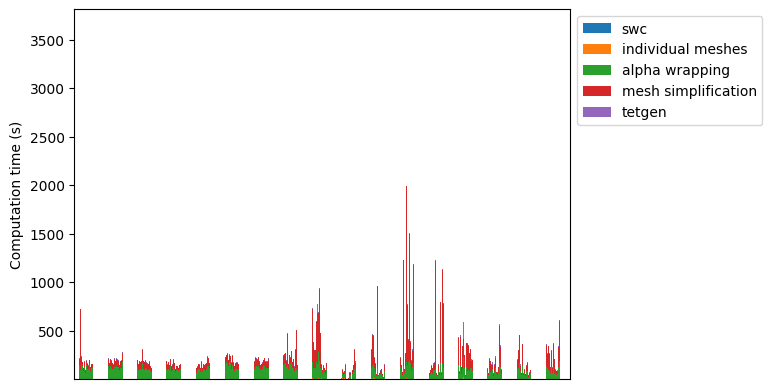

In [16]:
fig = plt.figure()
df.plot(kind='bar',stacked=True,rot=0)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False
    )
plt.ylabel('Computation time (s)')
plt.yscale('linear')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1),ncol=1, fancybox=True, shadow=False)
plt.savefig(f'{fig_dir}/time_bar.png')
plt.show()

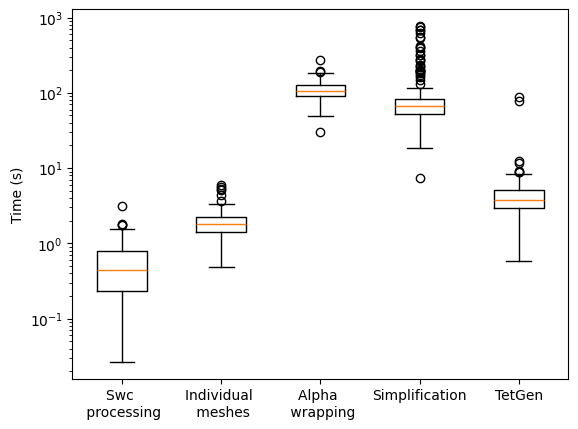

In [7]:
fig, ax = plt.subplots()
ax.boxplot(dict(df).values())
ax.set_xticklabels(('Swc \n processing','Individual \n meshes','Alpha \n wrapping','Simplification','TetGen'))
ax.set_ylabel('Time (s)')
ax.set_yscale('log')
plt.savefig(f'{fig_dir}/time_box.png')
plt.show()


<Figure size 640x480 with 0 Axes>

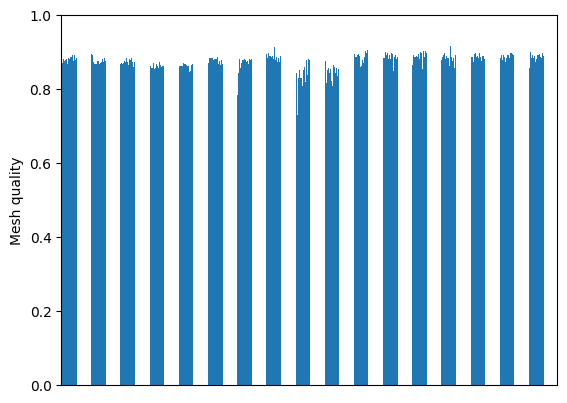

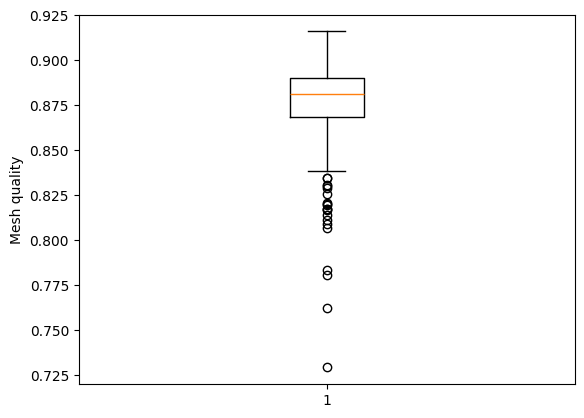

In [17]:
fig = plt.figure()
data.plot(y='mesh_quality',kind='bar',stacked=True,rot=0,legend=None)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
plt.ylabel('Mesh quality')
plt.ylim(0,1)
plt.savefig(f'{fig_dir}/quality_bar.png')

plt.show()


fig = plt.figure()
plt.boxplot(data['mesh_quality'])
plt.ylabel('Mesh quality')
plt.savefig(f'{fig_dir}/quality_box.png')

plt.show()


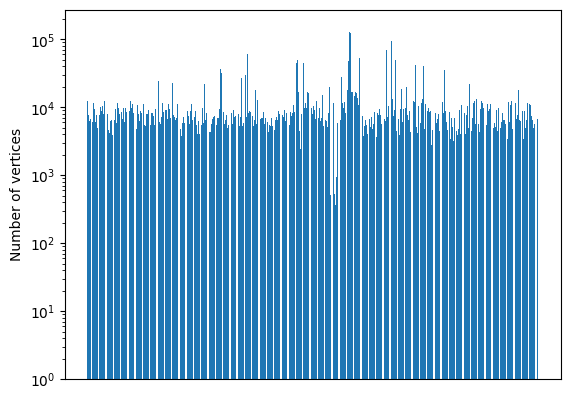

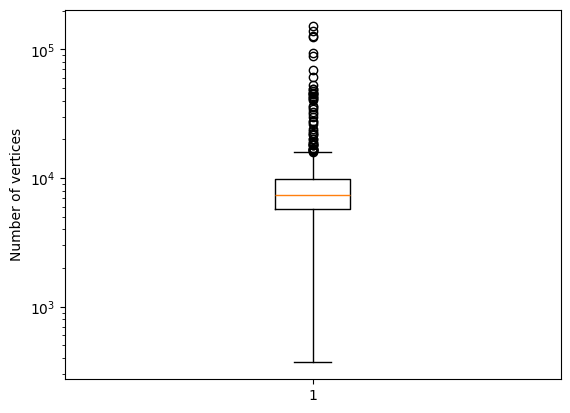

In [18]:
fig,ax = plt.subplots()
ax.bar(np.arange(0,len(data['vertex_number'])),np.array(data['vertex_number']),bottom=1)
ax.set_yscale('log')
ax.set_ylabel('Number of vertices')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
plt.savefig(f'{fig_dir}/size_bar.png')

plt.show()

fig,ax = plt.subplots()
ax.boxplot(data['vertex_number'])
ax.set_ylabel('Number of vertices')
ax.set_yscale('log')
plt.savefig(f'{fig_dir}/size_box.png')
plt.show()


In [49]:
data.keys()

Index(['morphology', 'vertex_number', 'face_number', 'surface_area', 'volume',
       'alpha_vertex_number', 'alpha_face_number', 'alpha_surface_area',
       'alpha_volume', 'mesh_quality', 'cleaned_swc_nodes', 'extract_swc',
       'reorder_swc', 'process_swc', 'initialise_branches',
       'initialising_individual_meshes', 'merging_individual_meshes',
       'alpha_wrap', 'simplify_mesh', 'tetgen'],
      dtype='object')

In [19]:
print(f'Mean number of vertices = {np.mean(data.vertex_number):.1f}, std dev = {np.std(data.vertex_number):.1f}, min = {min(data.vertex_number)}, max = {max(data.vertex_number)}')
print(f'Mean mesh quality = {np.mean(data.mesh_quality):.2f}, std dev = {np.std(data.mesh_quality):.2f}, min = {min(data.mesh_quality):.2f}, max = {max(data.mesh_quality):.2f}')


Mean number of vertices = 10844.8, std dev = 14751.8, min = 368, max = 150889
Mean mesh quality = 0.88, std dev = 0.02, min = 0.73, max = 0.92


In [20]:
total_time = np.sum(np.array(df)[:,1:],axis=1)

In [21]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

def get_regr_stats(x,y,normalize = True,xlabel=None,ylabel=None):
    x = np.array(x)
    y = np.array(y)
    if normalize:
        std_x = ((x - np.mean(x))/np.std(x)).reshape(-1,1)
        std_y = ((y - np.mean(y))/np.std(y)).reshape(-1,1)
    else:
        std_x = x.reshape(-1,1)
        std_y = y.reshape(-1,1)

    reg = linear_model.LinearRegression()
    reg.fit(std_x,std_y)
    a = reg.coef_
    std_y_predicted = reg.predict(std_x)
    print("Mean squared error: %.2f" % mean_squared_error(std_y, std_y_predicted))
    # The coefficient of determination: 1 is perfect prediction
    print("Coefficient of determination: %.2f" % r2_score(std_y, std_y_predicted))
    std_error = np.sqrt(mean_squared_error(std_y, std_y_predicted))
    fig = plt.figure()
    plt.scatter(std_x,std_y)
    plt.plot(std_x,std_y_predicted,'r')
    # plt.plot(std_complexity,std_time_predicted +std_error,'g')
    # plt.plot(std_complexity,std_time_predicted -std_error,'g',)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    plt.show()

In [13]:
len(data)

237

Number of nodes
Mean squared error: 71508.57
Coefficient of determination: 0.10


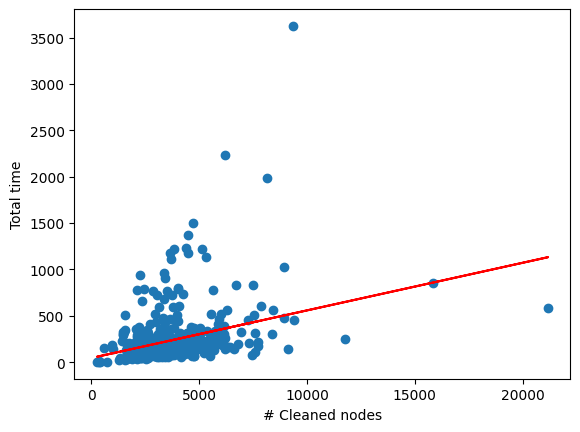

<Figure size 640x480 with 0 Axes>

In [22]:
# print('Complexity')
# get_regr_stats(complexity,total_time)
print('Number of nodes')
get_regr_stats(data.cleaned_swc_nodes,total_time,normalize=False,xlabel='# Cleaned nodes',ylabel='Total time')
plt.savefig(f'{fig_dir}/complexity.png')

# print('Surface area')
# get_regr_stats(data.surface_area,total_time)